## What an Image Actually Is
- An image is a discrete sampling of a continuous radiance field, stored as a rank-3 or rank-4 tensor
    - Most raw form: Image ∈ $ℝ^{H × W × C}$
    - Deep learning form: Batch ∈ $ℝ^{B × C × H × W}$
- An image is not reality — it is a grid of measurements sampled from a continuous light field and stored as numbers.

## Let's Load an Image of Dog and spectate it as a tensors

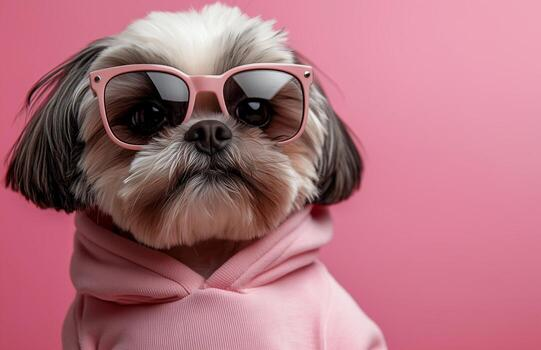

This is the Loaded Image 

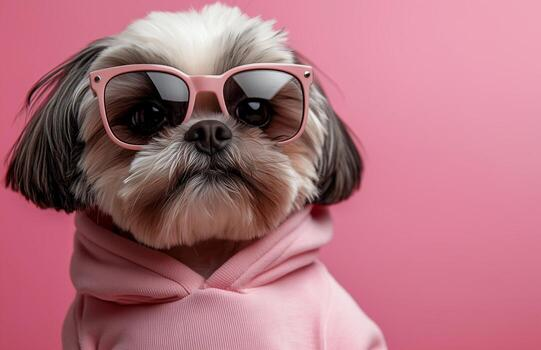

In [1]:
from PIL import Image
img = Image.open("../artifacts/dog_image_example.png")
print("This is the Loaded Image ", end = "")
img

## Let's Convert this image to PyTorch's tensor

In [2]:
import torch
import torchvision.transforms as T
img_tensor = T.PILToTensor()(img)
n_channels = img_tensor.shape[-3]
img_height = img_tensor.shape[-2]
img_width = img_tensor.shape[-1]
print(f"> Loaded Image Shape (C, H, W): {img_tensor.shape}") # (C, H, W)
print(f"> Meaning: We have {n_channels} channels Red, Green and Blue, each channel is of ({img_height}, {img_width}) shape")
print(f"> Because the Image is colorful we would expect C = {n_channels}, if it was grey scale we would assume C = {1}")

print("-------------------------------------------- Checking and converting dtype --------------------------------------------------------------------")
print(f"> Right now the Data type of each pixel values associated to the image is '{img_tensor.dtype}', this is dangerous for training the Model")
print(f"So we convert it to torch.float32 as, 'img_tensor.to(torch.float32)' ")

img_tensor = img_tensor.to(torch.float32)
# ----------------------------------------------------- NOTE -----------------------------------------------------

# Note: We will always get (H, W) as a pair
# Numpy and OpenCV expects, (H, W, C)
# PyTorch expects, (C, H, W)
# Later for Batch dim we use,
# images as (B, C, H, W) --> (batch_dim, channels, height, width)

# For the Loaded Image we will get,
# img_tensor.shape = (C, H, W) = (3, 350, 541)

> Loaded Image Shape (C, H, W): torch.Size([3, 350, 541])
> Meaning: We have 3 channels Red, Green and Blue, each channel is of (350, 541) shape
> Because the Image is colorful we would expect C = 3, if it was grey scale we would assume C = 1
-------------------------------------------- Checking and converting dtype --------------------------------------------------------------------
> Right now the Data type of each pixel values associated to the image is 'torch.uint8', this is dangerous for training the Model
So we convert it to torch.float32 as, 'img_tensor.to(torch.float32)' 


In [3]:
red_channel = img_tensor[0]
green_channel = img_tensor[1]
blue_channel = img_tensor[2]

In [4]:
red_channel[:2], green_channel[:2], blue_channel[:2]

(tensor([[204., 204., 204.,  ..., 238., 238., 238.],
         [204., 204., 204.,  ..., 238., 238., 238.]]),
 tensor([[100., 100., 100.,  ..., 167., 167., 167.],
         [100., 100., 100.,  ..., 167., 167., 167.]]),
 tensor([[123., 123., 123.,  ..., 185., 185., 185.],
         [123., 123., 123.,  ..., 185., 185., 185.]]))

In [5]:
len(red_channel.unique()), len(green_channel.unique()), len(blue_channel.unique())

(256, 252, 248)

## Let's Check the Pixel values Distribution

#### Why we need to check the distribution?
- Because models don’t learn images, they learn distributions of pixels
- If Distribution is broken then essentially the input to the model is Garbage
- So the Model will not be able to learn the actual distribution, it will try to learn this garbage distribution
- How to Stabilize the distribution? --> Normalize the Image

# Why we need to Normalize the Image?
### So That,
- optimization is well-conditioned
- representations are stationary (so every layer of the model won't have to adapt to the new representation)
- noise scales are meaningful
- iterative generative processes remain stable (Diffusion)

## What things to check in a plotted Histogram?

### 1️. Check for **Clipping**

**Clipping = mass accumulated at min/max boundaries**

#### Why clipping is dangerous for learning

If clipping exists:

* Gradients vanish at boundaries
* Convolutions lose contrast information
* Diffusion reverse process becomes ill-posed
* Model learns artifacts instead of structure
* **Information loss is irreversible** (normalization cannot fix it)

> Clipping is only dangerous when introduced by preprocessing errors.
> Natural saturation reflects the data distribution and is acceptable.
---

### 2️. Check whether the distribution is **centered along the x-axis**

#### Why centering matters

* Optimization assumes zero-mean inputs
* Non-centered data causes biased activations
* Leads to ill-conditioned loss surfaces
* Wastes model capacity on input correction
* Breaks noise–signal balance in diffusion models

> Centering aligns data with optimizer and architectural assumptions.

---

### 3️. Check whether **channels are balanced**

* Different channel distributions → color bias
* Early layers waste capacity correcting imbalance
* Slower convergence and unstable representations

- If channels are imbalanced:
    - First conv layers learn color normalization
    - Not edges, textures, or shapes
    - Capacity is wasted
    - Training becomes slower and less stable
> Balanced channels let early layers learn structure immediately.

> If channel histograms don’t overlap in scale and center, the model learns color correction before learning features.

---

## Summary

> **Histograms diagnose whether the model will learn structure or waste capacity fixing the input distribution.**


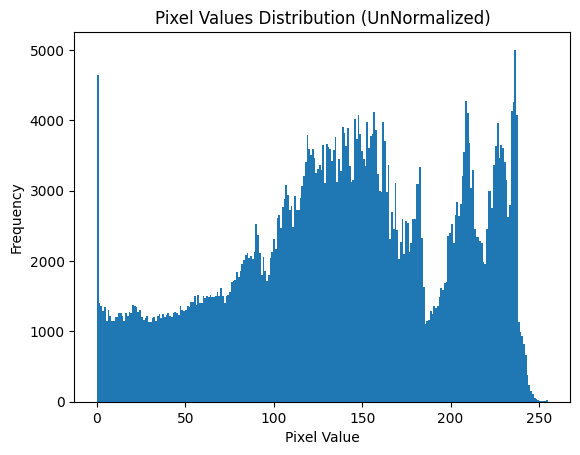

In [6]:
import matplotlib.pyplot as plt
plt.hist(img_tensor.flatten(), bins=256)
plt.title("Pixel Values Distribution (UnNormalized)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

# Intrepretation:
# Is it centered? --> No, Ranges from [0-255]
# Is it clipped? --> No, 
# Clipping Defination: 
    # A distribution is clipped when a non-trivial mass of values,
    # is forcibly stuck at the minimum or maximum representable value.
# Are channels balanced? --> No (I've checked this later in this Notebook)

# Note: If histogram is broken, training will be broken


## Conclusion (for this image)

**Is it centered?**
→ No. The distribution is strictly positive and not zero-centered.

**Is it clipped?**
→ No. There is no significant accumulation at the boundaries (0 or 255).

**Are channels balanced?**
→ No. Different channels have different marginal distributions.

## Let’s Normalize the Image Tensor

### Two Common Normalization Techniques

### 1️. Zero-Centered Normalization **(Expected by Diffusion Models)**

Maps pixel values to **[-1, 1]**

```python
img_norm = img_tensor / 127.5 - 1.0
```

* Centers distribution around 0
* Matches diffusion noise assumptions
* Stabilizes reverse sampling process

---

### 2. Unit Range Normalization **([0, 1])**

Maps pixel values to **[0, 1]**

```python
img_norm = img_tensor / 255.0
```

* Common for CNNs and classifiers
* Simpler but not diffusion-friendly

---

### Mental Model

> **Normalization aligns pixel distributions with model and optimization assumptions.**


In [7]:
img_norm = img_tensor / 127.5 - 1.0

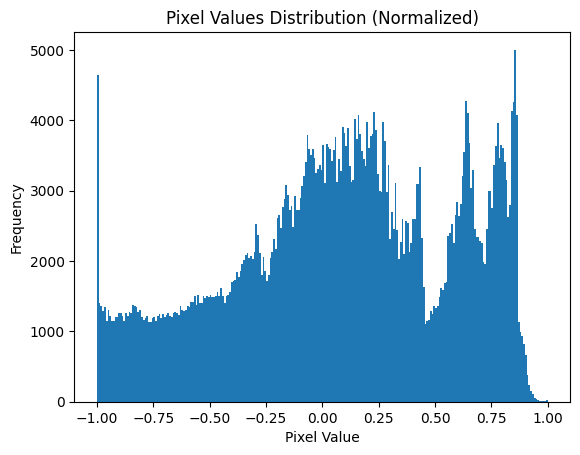

In [8]:
import matplotlib.pyplot as plt
plt.hist(img_norm.flatten(), bins=256)
plt.title("Pixel Values Distribution (Normalized)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

# Intrepretation:
# Is it centered? --> No
# Is it clipped? --> No
# Are channels balanced? --> No

# Note: If your histogram is broken, training will be broken

In [9]:
# Let's verify the Normalization
print(f"Min value = {img_norm.min()} | Max value = {img_norm.max()}")
print(f"Mean = {img_norm.mean():.3f} | Std = {img_norm.std():.3f}")

print("Expected values for a Normalized image tensor, Mean ~ 0, Std ~ [0.5-0.7]")

Min value = -1.0 | Max value = 1.0
Mean = 0.081 | Std = 0.502
Expected values for a Normalized image tensor, Mean ~ 0, Std ~ [0.5-0.7]


## Conclusion: 
- Images are probability distributions over tensors.
- Models approximate distributions, not semantics.
- If the distribution is wrong, the model is solving the wrong problem perfectly.

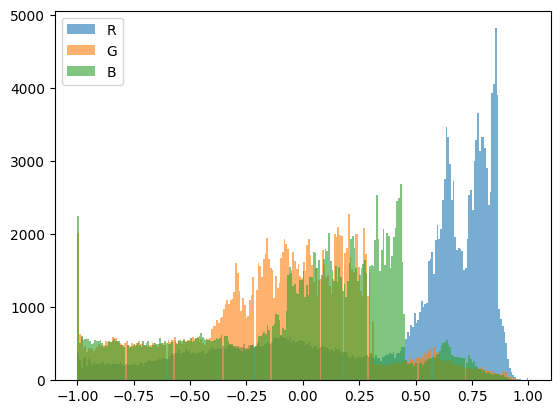

In [10]:
for c, name in zip(range(img_norm.shape[-3]), ["R", "G", "B"]):
    plt.hist(img_norm[c].flatten(), bins=256, alpha=0.6, label=name)
plt.legend()
plt.show()

In [11]:
for c, name in zip(range(3), ["Red", "Green", "Blue"]):
    print(f"for {name} channel, mean = {img_norm[c].mean().item():.3f}, std = {img_norm[c].std().item():.3f}")
print("→ Are channels balanced?")
print("     No, Different channels have different marginal distributions")

for Red channel, mean = 0.374, std = 0.513
for Green channel, mean = -0.112, std = 0.402
for Blue channel, mean = -0.018, std = 0.445
→ Are channels balanced?
     No, Different channels have different marginal distributions


## Now let's Apply this concept to new image

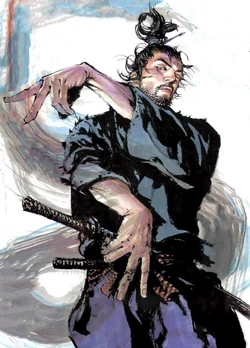

In [12]:
## Load the Image
from PIL import Image
img = Image.open("../artifacts/miyamoto_mushashi_img.png")
img

In [13]:
## Now convert this image to tensor
import torchvision.transforms as T
import torch
img_tensor = T.PILToTensor()(img)
print("dtype Before Conversion = ", img_tensor.dtype)
img_tensor = img_tensor.to(dtype = torch.float32)
print("dtype After Conversion = ", img_tensor.dtype)

dtype Before Conversion =  torch.uint8
dtype After Conversion =  torch.float32


In [14]:
## Checking shapes and Extracting the Channels
img_tensor_shape = img_tensor.shape # (C, H, W)
red_channel = img_tensor[-3][0]
green_channel = img_tensor[-3][1]
blue_channel = img_tensor[-3][2]
print(f"Red Channel: {red_channel[:2]} | Green Channel: {green_channel[:2]} | Blue Channel: {blue_channel[:2]}")

Red Channel: tensor([255., 255.]) | Green Channel: tensor([255., 255.]) | Blue Channel: tensor([255., 255.])


## Before Normalization

In [15]:
## Check Channel's Distribution
for channel_idx, channel_name in zip(range(img_tensor.shape[-3]), ["Red", "Green", "Blue"]):
    mean = img_tensor[channel_idx].mean()
    std = img_tensor[channel_idx].std()
    print(f"{channel_name}-channel: mean = {mean:.3f} | std = {std:.3f}")

print("> Notice how the distribution accross 3 channels are roughly the same")
print("> But we need to Normalize this image before feeding into the Model")

Red-channel: mean = 139.414 | std = 91.301
Green-channel: mean = 137.781 | std = 91.648
Blue-channel: mean = 140.690 | std = 91.206
> Notice how the distribution accross 3 channels are roughly the same
> But we need to Normalize this image before feeding into the Model


## After Normalization

In [16]:
## Check Channel's Distribution
img_tensor_norm = (img_tensor / 127.5) - 1.0 # Normalize this image
for channel_idx, channel_name in zip(range(img_tensor_norm.shape[-3]), ["Red", "Green", "Blue"]):
    mean = img_tensor_norm[channel_idx].mean()
    std = img_tensor_norm[channel_idx].std()
    print(f"{channel_name}-channel: mean = {mean:.3f} | std = {std:.3f}")

print("> Notice how the distribution accross 3 channels are roughly the same")

Red-channel: mean = 0.093 | std = 0.716
Green-channel: mean = 0.081 | std = 0.719
Blue-channel: mean = 0.103 | std = 0.715
> Notice how the distribution accross 3 channels are roughly the same


## Visualizing the Distribution of pixel values of image

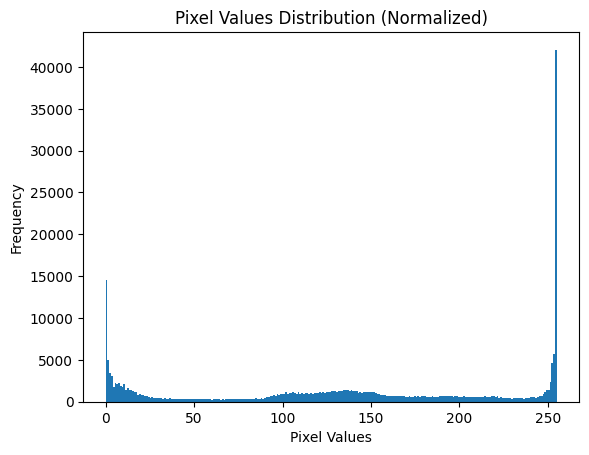

> Notice the mass accumulated near the boundaries
Clipping = non-trivial mass at min/max representable values
This clipping is data-induced (natural), not preprocessing-induced
Cause: high-contrast black-and-white (manga-style) image
Natural saturation is acceptable; artificial clipping is harmful


In [17]:
plt.title("Pixel Values Distribution (Normalized)")
plt.hist(img_tensor.flatten(), bins=256)
plt.xlabel("Pixel Values")
plt.ylabel("Frequency")
plt.show()

print("> Notice the mass accumulated near the boundaries")
print("Clipping = non-trivial mass at min/max representable values")

print("This clipping is data-induced (natural), not preprocessing-induced")
print("Cause: high-contrast black-and-white (manga-style) image")
print("Natural saturation is acceptable; artificial clipping is harmful")

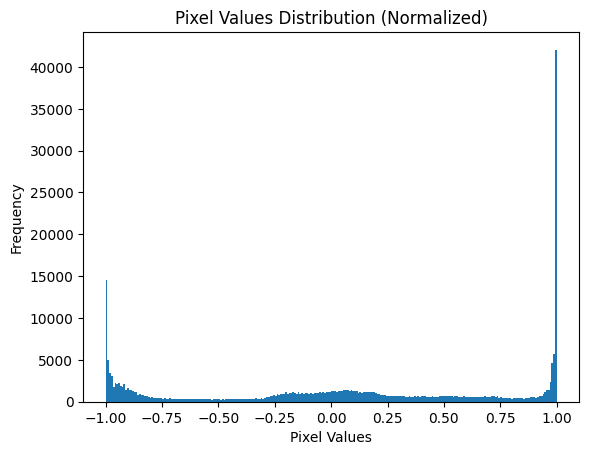

> Notice the mass accumulated near the boundaries
Clipping = non-trivial mass at min/max representable values
This clipping is data-induced (natural), not preprocessing-induced
Cause: high-contrast black-and-white (manga-style) image
Natural saturation is acceptable; artificial clipping is harmful


In [18]:
plt.title("Pixel Values Distribution (Normalized)")
plt.hist(img_tensor_norm.flatten(), bins=256)
plt.xlabel("Pixel Values")
plt.ylabel("Frequency")
plt.show()

print("> Notice the mass accumulated near the boundaries")
print("Clipping = non-trivial mass at min/max representable values")

print("This clipping is data-induced (natural), not preprocessing-induced")
print("Cause: high-contrast black-and-white (manga-style) image")
print("Natural saturation is acceptable; artificial clipping is harmful")

## Cross-channel distribution visualization

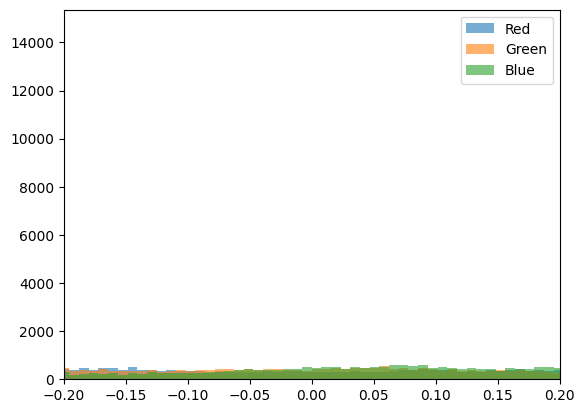

In [28]:
for channel_idx, channel_name in zip(range(img_tensor.shape[-3]), ["Red", "Green", "Blue"]):
    plt.xlim(-0.2, 0.2)   # zoom around the center
    plt.hist(img_tensor_norm[channel_idx].flatten(), bins = 256, alpha = 0.6, label = channel_name)
plt.legend()
plt.show()